In [1]:

from bs4 import BeautifulSoup 
import requests    
import pandas as pd
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
data  = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib")
table_contents = []
table = soup.find('table')

In [4]:
for row in table.findAll('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [5]:
df = pd.DataFrame(table_contents)
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [6]:
gc_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv")

In [7]:
Lat, Lon = [], []
pcodes = gc_df['Postal Code']
for postalcode in df['PostalCode'] : 
    for i, pcode in enumerate (pcodes):
        if (postalcode == pcode):
            lat = gc_df['Latitude'][i]
            lon = gc_df['Longitude'][i]
            Lat.append(lat)
            Lon.append(lon)

In [8]:

df['Latitude'] = Lat
df['Longitude'] = Lon
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [9]:
index_toronto = []

for i, borough in enumerate (df['Borough']):
    if 'Toronto' in borough :
        index_toronto.append(i)

toronto = df.iloc[index_toronto]

toronto.reset_index(drop=True, inplace=True)

toronto.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
9,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106


In [10]:
index_north_york = []

for i, borough in enumerate (df['Borough']):
    if 'North York' in borough :
        index_north_york.append(i)

north_york = df.iloc[index_north_york]

north_york.reset_index(drop=True, inplace=True)

north_york.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills North,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073
5,M3C,North York,Don Mills South,43.725900,-79.340923
6,M2H,North York,Hillcrest Village,43.803762,-79.363452
7,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259
8,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
9,M3J,North York,"Northwood Park, York University",43.767980,-79.487262


In [11]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
       
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],   
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Defining the number of venues
LIMIT = 100
CLIENT_ID='BD1TC52EYFGHXZRYM0CWBYYHWFD1WWNN11FXDZG31V3MSZ45'
CLIENT_SECRET='HZ0YJOFOEVU5UJIFXMNBPY2DMJ4AW3OEUPBDGRBQJ4N0J3WH'
VERSION = '20181020'
# Defining the radius
radius = 500

In [18]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude'])

In [19]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
5,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
6,"Regent Park, Harbourfront",43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
7,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
8,"Regent Park, Harbourfront",43.65426,-79.360636,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
9,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


In [20]:

north_york_venues = getNearbyVenues(names=north_york['Neighborhood'],
                                   latitudes=north_york['Latitude'],
                                   longitudes=north_york['Longitude'])


In [21]:
north_york_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
5,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
6,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection
7,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
8,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Roots,43.718214,-79.463893,Boutique
9,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Kitchen Stuff Plus (Clearance Outlet),43.719096,-79.462675,Furniture / Home Store


In [22]:
toronto_cat_values = toronto_venues['Venue Category'].value_counts().to_list()
toronto_cat_index = toronto_venues['Venue Category'].value_counts().index.to_list()
toronto_venue_cat = pd.DataFrame({'Venue Category' : toronto_cat_index, 'Total': toronto_cat_values})

In [23]:
ny_cat_values = north_york_venues['Venue Category'].value_counts().to_list()
ny_cat_index = north_york_venues['Venue Category'].value_counts().index.to_list()
ny_venue_cat = pd.DataFrame({'Venue Category' : ny_cat_index, 'Total': ny_cat_values})

In [24]:
list = ['Coffee Shop', 'Restaurant', 'Café']

In [25]:

toronto1 = toronto_venue_cat.loc[toronto_venue_cat['Venue Category'].isin(list)]
toronto1.head()

,Venue Category,Total
0,Coffee Shop,145
1,Café,84
2,Restaurant,54


In [26]:
ny2 = ny_venue_cat.loc[ny_venue_cat['Venue Category'].isin(list)]
ny2.head()

,Venue Category,Total
0,Coffee Shop,18
2,Restaurant,9
9,Café,6


In [27]:
cat_list = toronto1['Venue Category'].tolist()
total_toronto = toronto1['Total'].tolist()
total_ny = ny2['Total'].tolist()

In [28]:
data = pd.DataFrame({'Venue Category': cat_list, 'Toronto City' : total_toronto, 'North York': total_ny})
data.head()

,Venue Category,Toronto City,North York
0,Coffee Shop,145,18
1,Café,84,9
2,Restaurant,54,6


<AxesSubplot:ylabel='Venue Category'>

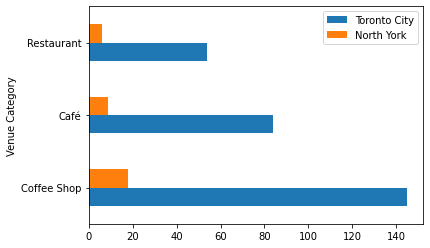

In [29]:

data.plot.barh(x='Venue Category')